# Quick Bite
Regularly measuring calorie intake presents significant challenges for the average consumer due to several factors. Accurately assessing portion sizes, interpreting nutritional labels, and accounting for the composition of meals, particularly in restaurant settings or with homemade recipes, can be complex and prone to error. Many food items lack readily accessible or clear calorie information, making estimation difficult and often leading to inaccuracies. Furthermore, the process of consistently monitoring and recording food consumption requires substantial effort and attention, which can become mentally taxing and time-intensive. While digital tools and applications may assist with tracking, they still demand active user input and adherence, contributing to the perceived burden of routine calorie monitoring.

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16, Xception, DenseNet121, MobileNetV2
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Dataset
Data Src: https://github.com/karansikka1/iFood_2019?tab=readme-ov-file

Dataset to 251 fine-grained (prepared) food categories with 118,475 training images collected from the web. We provide human verified labels for both the validation set of 11,994 images and the test set of 28,377 images.

In [ ]:
# Class list
class_list_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\class_list.txt"
class_mapping = {}

# Open the file and read the contents
with open(class_list_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        # Split each line by space to separate the index and the class name
        index, class_name = line.strip().split(' ', 1)
        # Convert the index to an integer and add the mapping to the dictionary
        class_mapping[int(index)] = class_name

In [ ]:
# Reduce classes after EDA process
keep_list = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\keep.csv"
df_keep = pd.read_csv(keep_list)
df_keep = df_keep[df_keep['Validate']=='TRUE']
print("Classes to train for :", len(df_keep))
classes_to_keep = df_keep['category_name'].tolist()

Classes to train for : 62


In [ ]:
# Convert to an array of label IDs for classes to keep
filtered_class_mapping = {index: class_name for index, class_name in class_mapping.items() if class_name in classes_to_keep}
print("Filtered class mapping:", len(filtered_class_mapping))
filtered_class_ids = list(map(str, filtered_class_mapping.keys()))

Filtered class mapping: 62


In [ ]:
# Check "bad" input test data
type_1_data = pd.read_csv(r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\df_eda.csv")
type_1_data = type_1_data[(type_1_data['is_cartoon'] == False) & (type_1_data['has_face'] == False) & (type_1_data['is_media_art'] == False) & (type_1_data['has_text'] == False)]
type_1_data = type_1_data['img_name'].to_list()

In [ ]:
# Paths to the dataset
train_dir = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set"
val_dir   = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\val_set\val_set"
test_dir  = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\test_set\test_set"

# Path to the labels
df_train = pd.read_csv(r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_labels.csv")
df_val   = pd.read_csv(r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\val_labels.csv")

# TypeError: If class_mode="categorical", y_col="label" column values must be type string, list or tuple.
df_train['label'] = df_train['label'].astype(str)
df_val['label']   = df_val['label'].astype(str)

# Filter datasets to just classifications of interest
df_train = df_train[df_train['label'].isin(filtered_class_ids)]
df_train = df_train[df_train['img_name'].isin(type_1_data)]
df_val   = df_val[df_val['label'].isin(filtered_class_ids)]

In [ ]:
# Hyperparameters
n_classes             = len(filtered_class_mapping) # Used to be class_mapping before dropping classes
img_width, img_height = 224, 224 # Required to be a 'square' for MobileNetv2
nb_train_samples      = df_train.shape[0]
nb_validation_samples = df_val.shape[0]
batch_size            = 64

### Generators
Docs : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale          = 1. / 255,   # Rescales the pixel values of the images to be in the range [0, 1] (from the original [0, 255]).
    shear_range      = 0.2,        # Randomly applies shearing transformations to the images with a shear intensity of 0.2.
    zoom_range       = 0.1,        # Randomly zooms in on images by up to 10% to make the model more robust to scale variations.
    horizontal_flip  = True,       # Randomly flips images horizontally to augment the dataset and improve generalization.
    rotation_range   = 30,         # Rotate images randomly within a range of 30 degrees
)

In [ ]:
val_datagen = ImageDataGenerator(
    rescale          = 1. / 255,   # Rescales the pixel values of the images to be in the range [0, 1] (from the original [0, 255]).
    shear_range      = 0.2,        # Randomly applies shearing transformations to the images with a shear intensity of 0.2.
    zoom_range       = 0.1,        # Randomly zooms in on images by up to 10% to make the model more robust to scale variations.
    horizontal_flip  = True,       # Randomly flips images horizontally to augment the dataset and improve generalization.
    rotation_range   = 30,         # Rotate images randomly within a range of 30 degrees
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col       = 'img_name',
    y_col       = 'label',
    directory   = train_dir,
    target_size = (img_height, img_width),
    batch_size  = batch_size,
    class_mode  = 'categorical',
    shuffle     = True,
    subset      = 'training'
)

Found 12092 validated image filenames belonging to 62 classes.


In [ ]:
validation_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col       = 'img_name',
    y_col       = 'label',
    directory   = val_dir,
    target_size = (img_height, img_width),
    batch_size  = batch_size,
    class_mode  = 'categorical',
    shuffle     = False,
)

Found 3079 validated image filenames belonging to 62 classes.


In [ ]:
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False  # No shuffling for test data
# )

## Create the Model
Set up the architecture and parameters

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape  = (img_height, img_width, 3),
    include_top  = False,
    weights      = 'imagenet',
    pooling      = 'avg'
    )

pretrained_model.trainable = True

In [ ]:
inputs  = pretrained_model.input
x       = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x       = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
model   = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# # Load the InceptionV3 model, pre-trained on ImageNet
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# # base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# base_model.trainable = True

In [ ]:
# model = Sequential([
#     # Data Augmentation Layers
#     RandomFlip('horizontal'),
#     RandomRotation(0.1),

#     # Pre-trained model (feature extractor)
#     base_model,

#     # GlobalAveragePooling2D directly after the pre-trained model
#     GlobalAveragePooling2D(),

#     # Adding fully connected layers
#     Dense(8, activation='relu'),
#     Dropout(0.5),

#     # Dense(128, activation='relu'),
#     # Dropout(0.5),

#     Dense(n_classes, activation='softmax')  # Assuming you're using categorical crossentropy
# ])

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001),  # Learning rate can be tuned
              loss      = 'categorical_crossentropy',
              metrics   = ['accuracy', tf.keras.metrics.AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001)

## Train the Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch  = nb_train_samples // batch_size,
    epochs           = 100,  # Number of epochs to fine-tune
    validation_data  = validation_generator,
    validation_steps = nb_validation_samples // batch_size,
    callbacks        = [early_stopping, reduce_lr]
)

# Some of the pretrained models on 1 epoch
# InceptionV3 : 0.0053
# VGG16       : 0.0052
# Xception    : 0.0049
# DenseNet121 : 0.0017
# MobileNetV2 : 0.0038

Epoch 1/100
188/188 [==============================] - 295s 2s/step - loss: 2.8874 - accuracy: 0.2842 - val_loss: 2.1110 - val_accuracy: 0.4385 - lr: 0.0010
Epoch 2/100
188/188 [==============================] - 280s 1s/step - loss: 1.9534 - accuracy: 0.4795 - val_loss: 1.8213 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 3/100
188/188 [==============================] - 588s 3s/step - loss: 1.7146 - accuracy: 0.5342 - val_loss: 1.8083 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 4/100
188/188 [==============================] - 266s 1s/step - loss: 1.5736 - accuracy: 0.5663 - val_loss: 1.7458 - val_accuracy: 0.5299 - lr: 0.0010
Epoch 5/100
188/188 [==============================] - 335s 2s/step - loss: 1.4649 - accuracy: 0.5987 - val_loss: 1.6427 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 6/100
188/188 [==============================] - 260s 1s/step - loss: 1.3536 - accuracy: 0.6197 - val_loss: 1.7525 - val_accuracy: 0.5247 - lr: 0.0010
Epoch 7/100
188/188 [==============================] - 260

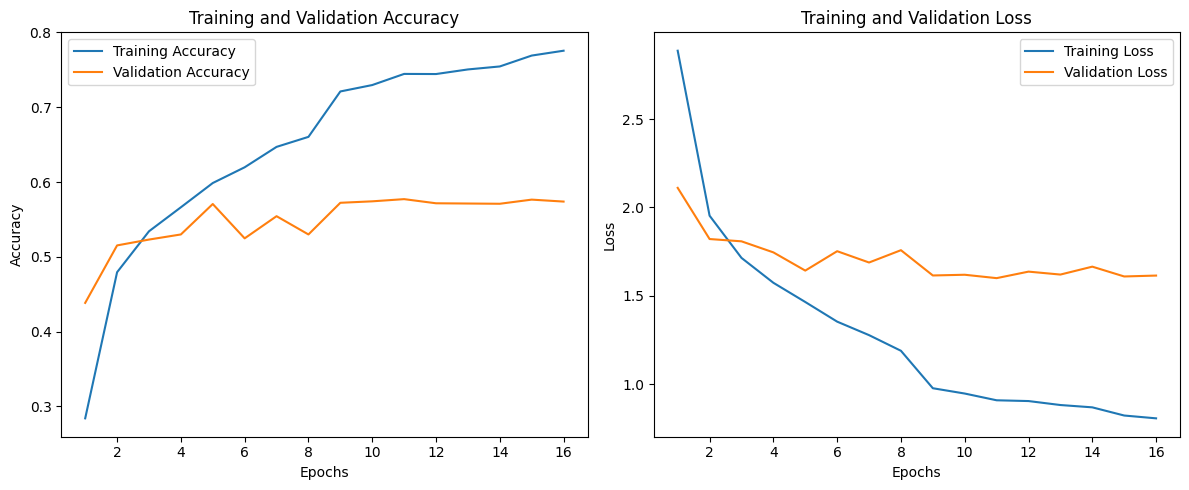

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

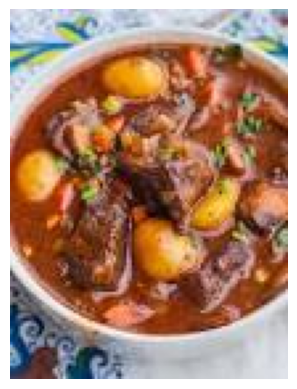

1/1 [==============================] - 0s 96ms/step
carrot_cake


In [ ]:
# Play with model
image_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\TEST_IMAGES\beef_stew\image_11.jpg"  # Replace with the path to your image
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

img = load_img(image_path, target_size=(img_height, img_width))

# Preprocess the image to be compatible with the model
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_mapping[predicted_class_index]
print(predicted_class_label)

In [ ]:
# import json

# # Load the .ipynb file
# with open('eat.ipynb', 'r', encoding='utf-8') as f:
#     notebook = json.load(f)

# # Extract code cells
# code_cells = [cell['source'] for cell in notebook['cells'] if cell['cell_type'] == 'code']

# # Write the code to a .py file
# with open('output.py', 'w', encoding='utf-8') as f:
#     for cell in code_cells:
#         f.write(''.join(cell) + '\n\n')